In [1]:
from typing import List, Tuple, Dict, Any, Optional
from pandarallel import pandarallel
import os
import re
import sys
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
import qiskit
import pennylane
import pytket
import bqskit

print(qiskit.__file__)
print(pennylane.__file__)
print(pytket.__file__)
print(bqskit.__file__)

print("qiskit:", qiskit.__version__)
print("pennylane:", pennylane.__version__)
print("pytket:", pytket.__version__)
print("bqskit:", bqskit.__version__)

/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/qiskit/__init__.py
/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/pennylane/__init__.py
/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/pytket/__init__.py
/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/bqskit/__init__.py
qiskit: 1.2.4
pennylane: 0.40.0
pytket: 1.33.1
bqskit: 1.2.0


## Coverage

In [41]:
BASE_PATH = "../program_bank/v036/2025_02_19__18_53"  # 1h - 1000 - 10 rounds

# BASE_PATH = "../program_bank/v036/2025_02_19__17_10"  # 1000 programs + rounds + coverage
# BASE_PATH = "../program_bank/v036/2025_02_19__14_12/"  # 1000 programs + rounds
# BASE_PATH = "../program_bank/v036/2025_02_19__12_05/"  # 1000 programs
# BASE_PATH = "../program_bank/v036/2025_02_18__21_06/"  # 10 programs

COVERAGE_PATH = os.path.join(BASE_PATH, "coverage.xml")

In [42]:
def get_coverage_info(platforms: List[str],
                      coverage_path: str) -> Dict[str, Dict[str, Any]]:
    """
    Given a list of platforms, returns the coverage information for each platform.

    Args:
        platforms (List[str]): List of platform names to extract coverage information for.
        coverage_path (str): Path to the coverage XML file.

    Returns:
        Dict[str, Dict[str, Any]]: Dictionary containing coverage information for each platform.
    """
    import xml.etree.ElementTree as ET

    # Parse the coverage.xml file
    tree = ET.parse(coverage_path)
    root = tree.getroot()

    # Initialize counters for each package
    package_coverage = {platform: {'covered': 0, 'total': 0}
                        for platform in platforms}

    # Extract package information
    packages = root.find('packages')
    for package in packages.findall('package'):
        package_name = package.get('name')

        # Extract class information
        classes = package.find('classes')
        for cls in classes.findall('class'):
            # Extract line information
            lines = cls.find('lines')
            for line in lines.findall('line'):
                hits = int(line.get('hits'))
                package_key = next(
                    (key for key in package_coverage.keys()
                     if key in package_name),
                    None)
                if package_key:
                    package_coverage[package_key]['total'] += 1
                    if hits > 0:
                        package_coverage[package_key]['covered'] += 1

    # Add percentage coverage
    for package, coverage in package_coverage.items():
        total_lines = coverage['total']
        covered_lines = coverage['covered']
        coverage_percentage = (
            covered_lines / total_lines) * 100 if total_lines > 0 else 0
        package_coverage[package]['coverage'] = coverage_percentage

    return package_coverage


# Example usage
platforms = [
    'qiskit', 'pennylane', 'pytket',
    # 'bqskit'
]
package_coverage = get_coverage_info(platforms, COVERAGE_PATH)
for package, coverage in package_coverage.items():
    print(
        f"{package:_<15}: {coverage['coverage']:.2f}% ({coverage['covered']}/{coverage['total']})")

qiskit_________: 5.65% (3288/58154)
pennylane______: 2.39% (1211/50666)
pytket_________: 5.96% (285/4779)


In [43]:
import xml.etree.ElementTree as ET
import random

# Fix the seed for reproducibility
random.seed(42)

# Initialize dictionaries to store uncovered and covered lines for each platform
uncovered_lines = {platform: [] for platform in package_coverage.keys()}
covered_lines = {platform: [] for platform in package_coverage.keys()}


# Parse the coverage.xml file
tree = ET.parse(COVERAGE_PATH)
root = tree.getroot()

# Extract package information
packages = root.find('packages')
for package in packages.findall('package'):
    package_name = package.get('name')

    # Extract class information
    classes = package.find('classes')
    for cls in classes.findall('class'):
        # Extract line information
        lines = cls.find('lines')
        for line in lines.findall('line'):
            hits = int(line.get('hits'))
            filename = cls.get('filename')
            line_number = line.get('number')
            for platform in package_coverage.keys():
                if platform in package_name:
                    if hits == 0:
                        uncovered_lines[platform].append(
                            (filename, line_number))
                    else:
                        covered_lines[platform].append((filename, line_number))

# Sample 30 uncovered lines from each platform
sampled_uncovered_lines = {
    platform: random.sample(lines, min(30, len(lines))) for platform,
    lines in uncovered_lines.items()}

# Store the result in a well-formed dictionary
result = {}
for platform, lines in sampled_uncovered_lines.items():
    result[platform] = []
    for filename, line_number in lines:
        line_number = int(line_number)
        with open(filename, 'r') as file:
            file_lines = file.readlines()
            start = max(0, line_number - 2)
            end = min(len(file_lines), line_number + 1)
            snippet = {'filename': filename, 'line_number': line_number, 'context': [
                f"{i + 1}: {file_lines[i].rstrip()}" for i in range(start, end)]}
            result[platform].append(snippet)

# Print the result
for platform, snippets in result.items():
    print(f"Platform: {platform}")
    for snippet in snippets:
        print(f"File: {snippet['filename']}, Line: {snippet['line_number']}")
        for line in snippet['context']:
            print(line)
        print("\n")

Platform: qiskit
File: /home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/qiskit/transpiler/passes/optimization/cx_cancellation.py, Line: 50
49:             chunk = []
50:             for i in range(len(cx_run) - 1):
51:                 chunk.append(cx_run[i])


File: /home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/qiskit/circuit/library/data_preparation/state_preparation.py, Line: 22
21: from qiskit.circuit.quantumregister import QuantumRegister
22: from qiskit.circuit.gate import Gate
23: from qiskit.circuit.library.standard_gates.x import XGate


File: /home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/qiskit/circuit/instruction.py, Line: 414
413:         """
414:         if isinstance(name, (str, type(None))):
415:             self._label = name


File: /home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/qiskit/visualization/bloch.py, Line: 441
440:         else:
441:             raise TypeError("Position needs to be specified b

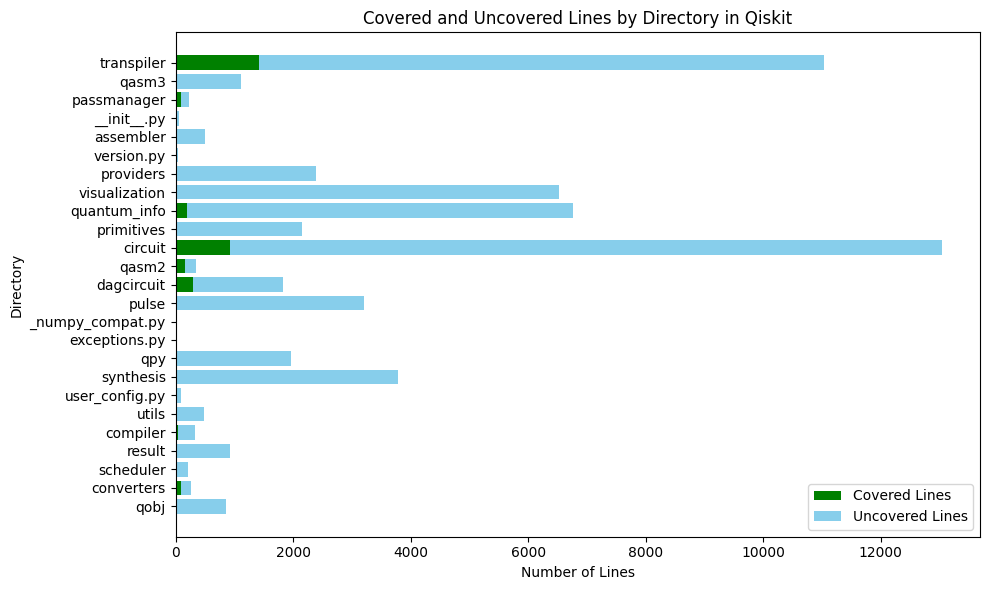

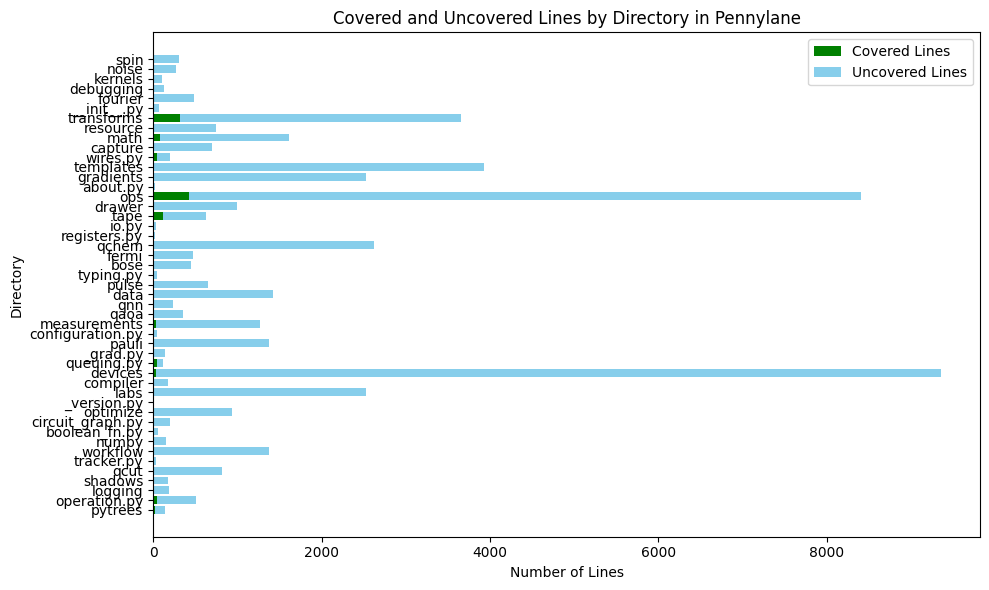

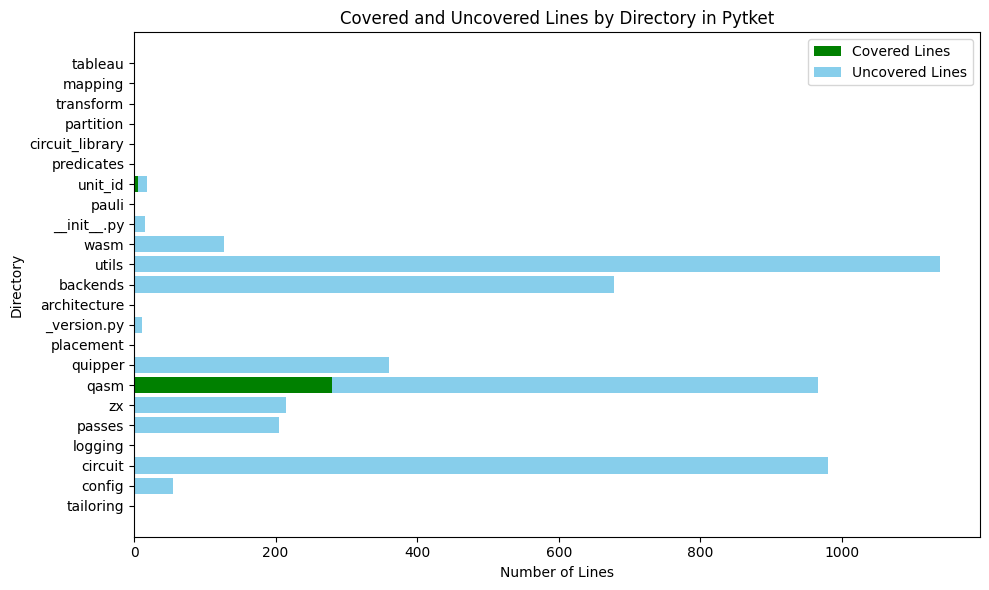

In [44]:
from collections import defaultdict
from pathlib import Path
from typing import List, Dict, Any
from rich.console import Console

console = Console()


def initialize_coverage_dicts(platforms: List[str]) -> Dict[str, defaultdict]:
    return {platform: defaultdict(int) for platform in platforms}


def update_coverage_dict(lines: List[Tuple[str, int]],
                         coverage_dict: Dict[str, defaultdict],
                         platform_name: str) -> None:
    for file_path, _ in lines:
        path_parts = file_path.split('/')
        if platform_name in path_parts:
            platform_index = path_parts.index(platform_name)
            if platform_index + 1 < len(path_parts):
                directory_name = path_parts[platform_index + 1]
                coverage_dict[platform_name][directory_name] += 1


def ensure_all_directories_present(platforms: List[str],
                                   covered_dict: Dict[str, defaultdict],
                                   uncovered_dict: Dict[str, defaultdict]) -> Dict[str, set]:
    return {platform: set(covered_dict[platform].keys()).union(set(uncovered_dict[platform].keys()))
            for platform in platforms}


def get_directory_counts(all_directories: Dict[str, set],
                         coverage_dict: Dict[str, defaultdict],
                         platform_name: str) -> List[int]:
    return [coverage_dict[platform_name][directory] for directory in all_directories[platform_name]]


def plot_coverage_histogram(platform_name: str,
                            all_directories: Dict[str, set],
                            covered_counts: List[int],
                            uncovered_counts: List[int]) -> None:
    plt.figure(figsize=(10, 6))
    plt.barh(
        list(all_directories[platform_name]),
        covered_counts, color='green', label='Covered Lines')
    plt.barh(
        list(all_directories[platform_name]),
        uncovered_counts, left=covered_counts, color='skyblue',
        label='Uncovered Lines')
    plt.ylabel('Directory')
    plt.xlabel('Number of Lines')
    plt.title(
        f'Covered and Uncovered Lines by Directory in {platform_name.capitalize()}')
    plt.legend()
    plt.yticks(ha='right')
    plt.tight_layout()
    plt.show()


platform_names = list(covered_lines.keys())
covered_directory_counts = initialize_coverage_dicts(platform_names)
uncovered_directory_counts = initialize_coverage_dicts(platform_names)

for platform_name in platform_names:
    update_coverage_dict(lines=covered_lines[platform_name],
                         coverage_dict=covered_directory_counts,
                         platform_name=platform_name)
    update_coverage_dict(lines=uncovered_lines[platform_name],
                         coverage_dict=uncovered_directory_counts,
                         platform_name=platform_name)

all_directories = ensure_all_directories_present(
    platforms=platform_names, covered_dict=covered_directory_counts,
    uncovered_dict=uncovered_directory_counts)
uncovered_line_counts = {
    platform_name:
    get_directory_counts(
        all_directories=all_directories,
        coverage_dict=uncovered_directory_counts,
        platform_name=platform_name)
    for platform_name in platform_names}
covered_line_counts = {
    platform_name:
    get_directory_counts(
        all_directories=all_directories,
        coverage_dict=covered_directory_counts,
        platform_name=platform_name)
    for platform_name in platform_names}

for platform_name in platform_names:
    plot_coverage_histogram(
        platform_name=platform_name, all_directories=all_directories,
        covered_counts=covered_line_counts[platform_name],
        uncovered_counts=uncovered_line_counts[platform_name])

In [45]:
# uncovered_lines_qiskit = uncovered_lines['qiskit']

# # print the stats on how many uncovered lines end with .rs in percentage
# rs_files = [
#     filename for filename, _ in uncovered_lines_qiskit
#     if filename.endswith('.rs')]
# rs_uncovered_lines = [line for filename,
#                       line in uncovered_lines_qiskit if filename in rs_files]
# rs_uncovered_lines_percentage = (
#     len(rs_uncovered_lines) / len(uncovered_lines_qiskit)) * 100
# print(
#     f"Percentage of uncovered lines ending with .rs: {rs_uncovered_lines_percentage:.2f}%")

# # check how many include test_ in the name
# test_files = [filename for filename,
#               _ in uncovered_lines_qiskit if 'test_' in filename]
# test_uncovered_lines = [
#     line for filename, line in uncovered_lines_qiskit
#     if filename in test_files]
# test_uncovered_lines_percentage = (
#     len(test_uncovered_lines) / len(uncovered_lines_qiskit)) * 100
# print(
#     f"Percentage of uncovered lines with 'test_' in the name: {test_uncovered_lines_percentage:.2f}%")

# Chain Length Analysis

## Coverage

In [46]:
# read the coverage in subfodlers cov_round_{int} read with the above function get_coverage_info

all_cov_subfolders = [
    f for f in os.listdir(BASE_PATH) if f.startswith('cov_round')]
all_cov_subfolders.sort()

# create a df
records = []
for cov_subfolder in all_cov_subfolders:
    coverage_path = os.path.join(BASE_PATH, cov_subfolder, "coverage.xml")
    coverage_info = get_coverage_info(platforms, coverage_path)
    i_round = int(cov_subfolder.split('_')[-1])
    for platform, coverage in coverage_info.items():
        new_record = coverage
        new_record['platform'] = platform
        new_record['round'] = i_round
        records.append(new_record)

df_coverage = pd.DataFrame(records)
df_coverage.head()

# Read cumulative coverage files
cumulative_coverage_files = [
    f for f in os.listdir(os.path.join(BASE_PATH, "cumulative_coverage"))
    if f.startswith('coverage_up_to_')]
cumulative_coverage_files.sort()

# Create a DataFrame for cumulative coverage
cumulative_records = []
for coverage_file in cumulative_coverage_files:
    coverage_path = os.path.join(
        BASE_PATH, "cumulative_coverage", coverage_file)
    print(coverage_path)
    coverage_info = get_coverage_info(platforms, coverage_path)
    i_round = int(coverage_file.split('_')[-1].split('.')[0])
    for platform, coverage in coverage_info.items():
        new_record = coverage
        new_record['platform'] = platform
        new_record['round'] = i_round
        cumulative_records.append(new_record)

df_cumulative_coverage = pd.DataFrame(cumulative_records)
df_cumulative_coverage.head()

../program_bank/v036/2025_02_19__18_53/cumulative_coverage/coverage_up_to_1.xml
../program_bank/v036/2025_02_19__18_53/cumulative_coverage/coverage_up_to_10.xml
../program_bank/v036/2025_02_19__18_53/cumulative_coverage/coverage_up_to_2.xml
../program_bank/v036/2025_02_19__18_53/cumulative_coverage/coverage_up_to_3.xml
../program_bank/v036/2025_02_19__18_53/cumulative_coverage/coverage_up_to_4.xml
../program_bank/v036/2025_02_19__18_53/cumulative_coverage/coverage_up_to_5.xml
../program_bank/v036/2025_02_19__18_53/cumulative_coverage/coverage_up_to_6.xml
../program_bank/v036/2025_02_19__18_53/cumulative_coverage/coverage_up_to_7.xml
../program_bank/v036/2025_02_19__18_53/cumulative_coverage/coverage_up_to_8.xml
../program_bank/v036/2025_02_19__18_53/cumulative_coverage/coverage_up_to_9.xml


,covered,total,coverage,platform,round
0,3063,58154,5.267050,qiskit,1
1,1155,50666,2.279635,pennylane,1
2,248,4779,5.189370,pytket,1
3,3288,58154,5.653953,qiskit,10
4,1211,50666,2.390163,pennylane,10


## Unique Programs

In [47]:
from qiskit import QuantumCircuit
from qiskit.qasm2 import load, LEGACY_CUSTOM_INSTRUCTIONS
from multiprocessing import Pool


def analyze_qasm_file(file_path: str) -> Dict[str, Any]:
    """
    Analyze a single QASM file for gate counts.

    Args:
        file_path (str): The path to the QASM file.

    Returns:
        Dict[str, Any]: Dictionary containing the file name, total number of gates, and number of unique gate types.
    """
    qasm_file = os.path.basename(file_path)
    try:
        qc = load(file_path, custom_instructions=LEGACY_CUSTOM_INSTRUCTIONS)
        gate_counts = qc.count_ops()
        total_gates = sum(gate_counts.values())
        unique_gates = len(gate_counts)
    except Exception as e:
        total_gates = -1
        unique_gates = -1
    return {
        'filepath': qasm_file,
        'fileprefix': Path(qasm_file).stem,
        'tot_gates': total_gates,
        'unique_gates': unique_gates}


def analyze_qasm_files(base_path: str) -> pd.DataFrame:
    """
    Analyze QASM files for gate counts.

    Args:
        base_path (str): The directory path where the QASM files are located.

    Returns:
        pd.DataFrame: DataFrame containing the total number of gates and the number of unique gate types in each file.
    """
    qasm_files = [os.path.join(base_path, f)
                  for f in os.listdir(base_path) if f.endswith('.qasm')]

    with Pool() as pool:
        data = pool.map(analyze_qasm_file, qasm_files)

    df = pd.DataFrame(data)
    return df


# Analyze QASM files and display the first few rows of the DataFrame
df_qasm_analysis = analyze_qasm_files(BASE_PATH)
df_qasm_analysis.head()

,filepath,fileprefix,tot_gates,unique_gates
0,0000173_26b317.qasm,0000173_26b317,15,13
1,0001024_qite_d7bb6c.qasm,0001024_qite_d7bb6c,22,4
2,0000578_qite_15424a.qasm,0000578_qite_15424a,83,5
3,0000562_qite_d5dde2.qasm,0000562_qite_d5dde2,151,3
4,0002059_qite_e0eb2b.qasm,0002059_qite_e0eb2b,64,4


In [48]:
from multiprocessing import Pool
import glob


def read_metadata_file(file_path: str) -> Dict[str, Any]:
    """
    Read a single metadata JSON file and return its content along with the filename.

    Args:
        file_path (str): The path to the metadata JSON file.

    Returns:
        Dict[str, Any]: Dictionary containing the json dictionary including
        the field "filepath" with the filename.
    """
    with open(file_path, 'r') as file:
        data = json.load(file)
    data['filepath'] = os.path.basename(file_path)
    data['fileprefix'] = Path(file_path).stem
    return data


def read_metadata_files(base_path: str) -> pd.DataFrame:
    """
    Read metadata JSON files and store their content in a DataFrame.

    Args:
        base_path (str): The directory path where the metadata JSON files are located.

    Returns:
        pd.DataFrame: DataFrame containing the filename and the content of each JSON file.
    """
    metadata_files = glob.glob(os.path.join(base_path, 'metadata', '*.json'))

    with Pool() as pool:
        data = pool.map(read_metadata_file, metadata_files)

    df = pd.DataFrame(data)
    return df


# Read metadata files and store in DataFrame
df_program_metadata = read_metadata_files(BASE_PATH)
df_program_metadata.head()

,input_qasm,platform,round,importer_function,transformer_functions,exporter_function,importer_time,transformation_time,exporter_time,output_qasm,filepath,fileprefix
0,program_bank/v036/2025_02_19__18_53/0001196_qi...,pennylane,10,pennylane_import,[pennylane_optimizer_cancel_inverses],pennylane_export,0.009380,[2.8371810913085938e-05],0.120514,program_bank/v036/2025_02_19__18_53/0001196_qi...,0001196_qite_963a80.json,0001196_qite_963a80
1,program_bank/v036/2025_02_19__18_53/0002304_qi...,pytket,8,pytket_import,[pytket_change_gateset_U3_CX],pytket_export,0.020273,[0.0009720325469970703],0.010118,program_bank/v036/2025_02_19__18_53/0002304_qi...,0002304_qite_bccc5a.json,0002304_qite_bccc5a
2,program_bank/v036/2025_02_19__18_53/0001934_c9...,qiskit,1,qiskit_import,[qiskit_change_gateset_rx_ry_rz_cz],qiskit_export,0.001020,[0.06044316291809082],0.002678,program_bank/v036/2025_02_19__18_53/0001934_qi...,0001934_qite_3d36e0.json,0001934_qite_3d36e0
3,program_bank/v036/2025_02_19__18_53/0002062_qi...,pytket,2,pytket_import,[pytket_optimizer_optimise_phase_gadgets],pytket_export,0.024756,[0.059279441833496094],0.009485,program_bank/v036/2025_02_19__18_53/0002062_qi...,0002062_qite_4dc86e.json,0002062_qite_4dc86e
4,program_bank/v036/2025_02_19__18_53/0002675_qi...,pennylane,2,pennylane_import,[pennylane_optimizer_decompose],pennylane_export,0.000905,[2.47955322265625e-05],0.041124,program_bank/v036/2025_02_19__18_53/0002675_qi...,0002675_qite_6d6edd.json,0002675_qite_6d6edd


In [49]:
# merge on the file prefix to get the metadata for each qasm file
df_program_and_metadata = pd.merge(
    df_qasm_analysis, df_program_metadata, on='fileprefix')
df_program_and_metadata.head()

,filepath_x,fileprefix,tot_gates,unique_gates,input_qasm,platform,round,importer_function,transformer_functions,exporter_function,importer_time,transformation_time,exporter_time,output_qasm,filepath_y
0,0001024_qite_d7bb6c.qasm,0001024_qite_d7bb6c,22,4,program_bank/v036/2025_02_19__18_53/0001024_qi...,pytket,4,pytket_import,[pytket_optimizer_remove_redundancies],pytket_export,0.006517,[0.00031065940856933594],0.003403,program_bank/v036/2025_02_19__18_53/0001024_qi...,0001024_qite_d7bb6c.json
1,0000578_qite_15424a.qasm,0000578_qite_15424a,83,5,program_bank/v036/2025_02_19__18_53/0000578_qi...,pennylane,8,pennylane_import,[pennylane_optimizer_unitary_to_rot],pennylane_export,0.002328,[3.62396240234375e-05],0.013695,program_bank/v036/2025_02_19__18_53/0000578_qi...,0000578_qite_15424a.json
2,0000562_qite_d5dde2.qasm,0000562_qite_d5dde2,151,3,program_bank/v036/2025_02_19__18_53/0000562_qi...,pytket,5,pytket_import,[pytket_optimizer_remove_redundancies],pytket_export,0.037772,[0.0010428428649902344],0.013345,program_bank/v036/2025_02_19__18_53/0000562_qi...,0000562_qite_d5dde2.json
3,0002059_qite_e0eb2b.qasm,0002059_qite_e0eb2b,64,4,program_bank/v036/2025_02_19__18_53/0002059_qi...,qiskit,5,qiskit_import,[qiskit_change_gateset_rx_ry_rz_cz],qiskit_export,0.002681,[0.023499488830566406],0.002634,program_bank/v036/2025_02_19__18_53/0002059_qi...,0002059_qite_e0eb2b.json
4,0000260_qite_f8a325.qasm,0000260_qite_f8a325,90,4,program_bank/v036/2025_02_19__18_53/0000260_qi...,qiskit,2,qiskit_import,[qiskit_change_gateset_u1_u2_u3_cx],qiskit_export,0.003104,[0.037301063537597656],0.003953,program_bank/v036/2025_02_19__18_53/0000260_qi...,0000260_qite_f8a325.json


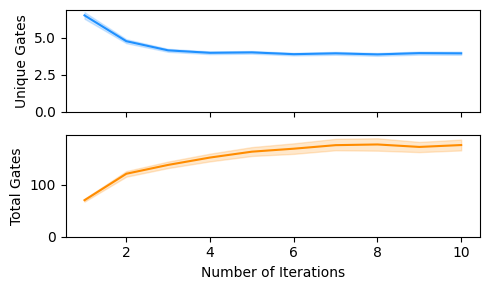

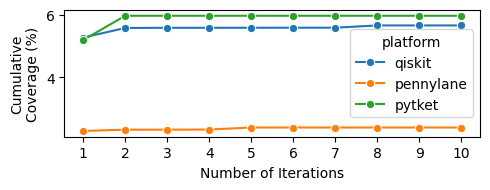

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

df_program_and_metadata['selection_method'] = 'depth-first'

# Plot gates and program diversity
fig, (ax_unique_gates, ax_total_gates) = plt.subplots(
    2, 1, figsize=(5, 3), sharex=True)

sns.lineplot(
    data=df_program_and_metadata,
    x='round',
    y='unique_gates',
    color="dodgerblue",
    ax=ax_unique_gates
)
ax_unique_gates.set_ylabel('Unique Gates')
ax_unique_gates.set_ylim(bottom=0)

sns.lineplot(
    data=df_program_and_metadata,
    x='round',
    y='tot_gates',
    color="darkorange",
    ax=ax_total_gates
)
ax_total_gates.set_ylabel('Total Gates')
ax_total_gates.set_xlabel('Number of Iterations')
ax_total_gates.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# Save the figure
output_path = os.path.join("images", "chain_length_vs_program_diversity.pdf")
fig.savefig(output_path)

# Plot coverage
fig, ax_coverage = plt.subplots(figsize=(5, 2))

sns.lineplot(
    data=df_cumulative_coverage,
    x='round',
    y='coverage',
    hue='platform',
    marker='o',
    ax=ax_coverage
)
ax_coverage.set_ylabel('Cumulative\nCoverage (%)')
ax_coverage.set_xlabel('Number of Iterations')

plt.xticks(
    ticks=range(
        df_program_and_metadata['round'].min(),
        df_program_and_metadata['round'].max() + 1))
plt.tight_layout()
plt.show()

# Save the figure
output_path = os.path.join("images", "chain_length_vs_coverage.pdf")
fig.savefig(output_path)

# Compare with MorphQ

In [240]:
MORPHQ_COVERAGE_PATH_1h = "/home/paltenmo/projects/morphq_upgraded/MorphQ-Quantum-Qiskit-Testing-ICSE-23/data/qmt_v11/coverage.xml"

In [241]:
cov_morphq_1h = get_coverage_info(
    platforms=["qiskit"],
    coverage_path=MORPHQ_COVERAGE_PATH_1h
)
cov_morphq_1h

{'qiskit': {'covered': 5830, 'total': 58920, 'coverage': 9.894772572980312}}

In [242]:
import xml.etree.ElementTree as ET


def get_line_in_coverage(target_package: str, coverage_path: str,
                         are_covered: bool) -> List[str]:
    """Get the line of covered (or uncovered) lines.

    The coverage path points to the xml file generated by coverage.py

    The output format is the filepath:line_number
    Where the filepath is relative to the site-packages directory.
    """
    covered_lines = []

    # Parse the coverage.xml file
    tree = ET.parse(coverage_path)
    root = tree.getroot()

    # Extract package information
    packages = root.find('packages')
    for package in packages.findall('package'):
        package_name = package.get('name')
        if f".site-packages.{target_package}." in package_name:
            # Extract class information
            classes = package.find('classes')
            for cls in classes.findall('class'):
                filename = cls.get('filename')
                # Extract line information
                lines = cls.find('lines')
                for line in lines.findall('line'):
                    hits = int(line.get('hits'))
                    if (are_covered and hits > 0) or (not are_covered and hits == 0):
                        line_number = line.get('number')
                        filename_relative = filename.split("site-packages")[-1]
                        covered_lines.append(
                            f"{filename_relative}:{line_number}")

    return covered_lines


covered_lines_morphq_1h = get_line_in_coverage(
    target_package="qiskit",
    coverage_path=MORPHQ_COVERAGE_PATH_1h,
    are_covered=True
)
print(covered_lines_morphq_1h[:5])

covered_lines_our_approach = get_line_in_coverage(
    target_package="qiskit",
    coverage_path=COVERAGE_PATH,
    are_covered=True
)
print(covered_lines_our_approach[:5])

['/qiskit/circuit/_classical_resource_map.py:50', '/qiskit/circuit/_classical_resource_map.py:51', '/qiskit/circuit/_classical_resource_map.py:52', '/qiskit/circuit/_classical_resource_map.py:53', '/qiskit/circuit/_classical_resource_map.py:54']
['/qiskit/circuit/_classical_resource_map.py:50', '/qiskit/circuit/_classical_resource_map.py:51', '/qiskit/circuit/_classical_resource_map.py:52', '/qiskit/circuit/_classical_resource_map.py:53', '/qiskit/circuit/_classical_resource_map.py:54']


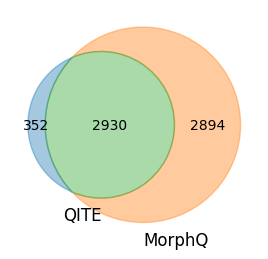

In [ ]:
from matplotlib_venn import venn2
import seaborn as sns

import matplotlib.pyplot as plt


def plot_covered_lines_venn(
        set1: set, set2: set, label1: str, label2: str) -> Tuple[
        plt.Figure, plt.Axes]:
    """
    Plot a Venn diagram showing the intersection between two sets of covered lines.

    Args:
        set1 (set): First set of covered lines.
        set2 (set): Second set of covered lines.
        label1 (str): Label for the first set.
        label2 (str): Label for the second set.

    Returns:
        Tuple[plt.Figure, plt.Axes]: The figure and axes of the Venn diagram.
    """
    # Compute the intersection and differences
    only_set1 = set1 - set2
    only_set2 = set2 - set1
    intersection = set1 & set2

    # Create the Venn diagram
    fig, ax = plt.subplots(figsize=(6, 3))
    venn = venn2([set1, set2], (label1, label2), ax=ax)

    # Set colors using seaborn palette
    colors = sns.color_palette("tab10", 3)
    venn.get_label_by_id('10').set_text(len(only_set1))
    venn.get_label_by_id('01').set_text(len(only_set2))
    venn.get_label_by_id('11').set_text(len(intersection))

    # Set colors
    venn.get_patch_by_id('10').set_color(colors[0])
    venn.get_patch_by_id('01').set_color(colors[1])
    venn.get_patch_by_id('11').set_color(colors[2])

    # Add title
    plt.show()

    return fig, ax


# Example usage
set_our_approach = set(covered_lines_our_approach)
set_morphq = set(covered_lines_morphq_1h)
fig, ax = plot_covered_lines_venn(
    set_our_approach, set_morphq, 'QITE', 'MorphQ')

# Save the Venn diagram as an image with a meaningful name
output_path_venn = os.path.join(
    "images", "comparison_morphq_covered_lines_venn.pdf")
fig.savefig(output_path_venn)

In [246]:
import random

qiskit_path_morphq = "/home/paltenmo/.conda/envs/MorphQ-v1-2-4/lib/python3.10/site-packages/"
qiskit_path_our_approach = "/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/"

QISKIT_PATH = qiskit_path_our_approach

# Fix the seed for reproducibility
random.seed(42)

# Find the lines that are in our approach but not in MorphQ
unique_our_approach = set_our_approach - set_morphq

# Sample 20 lines
sampled_lines = random.sample(unique_our_approach, 20)

# Print the sampled lines with the exact line content
for line in sampled_lines:
    filename, line_number = line.split(':')
    line_number = int(line_number)
    # remove leading slash
    filename = filename[1:]
    full_path = Path(QISKIT_PATH) / filename
    print(f"{full_path}:{line_number}")
    with open(full_path, 'r') as file:
        file_lines = file.readlines()
        print(file_lines[line_number - 1])

/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/qiskit/circuit/tools/pi_check.py:151
            return str_out

/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/qiskit/qasm2/export.py:267
    if instruction.clbits:

/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/qiskit/circuit/singleton.py:308
                return self.base_class(*args, **kwargs, _force_mutable=True)

/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/qiskit/circuit/tools/pi_check.py:176
    complex_inpt = complex(inpt)

/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/qiskit/qasm2/export.py:324
        return operation

/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/qiskit/qasm2/parse.py:254
            qc._append(

/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/qiskit/qasm2/__init__.py:630
    filename = Path(filename)

/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/qiskit/qasm2/parse.py:2

/tmp/ipykernel_3624800/3757551985.py:15: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_lines = random.sample(unique_our_approach, 20)


In [104]:
! pip show qiskit qiskit-aer qiskit-ibm-runtime

Name: qiskit
Version: 1.2.4
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages
Requires: dill, numpy, python-dateutil, rustworkx, scipy, stevedore, symengine, sympy, typing-extensions
Required-by: mqt.qcec, PennyLane-qiskit, pytket-qiskit, qiskit-aer, qiskit-ibm-provider, qiskit-ibm-runtime, qiskit-qasm3-import
---
Name: qiskit-aer
Version: 0.15.1
Summary: Aer - High performance simulators for Qiskit
Home-page: https://github.com/Qiskit/qiskit-aer
Author: AER Development Team
Author-email: qiskit@us.ibm.com
License: Apache 2.0
Location: /home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages
Requires: numpy, psutil, qiskit, scipy
Required-by: PennyLane-qiskit, pytket-qiskit
---
Name: qiskit-ibm

## Number of Warnings

In [149]:
import sqlite3 as sl

BASE_MORPHQ_PATH = "/home/paltenmo/projects/morphq_upgraded/MorphQ-Quantum-Qiskit-Testing-ICSE-23/"

PATH_PROGRAMS = Path(BASE_MORPHQ_PATH) / "data/qmt_v11/programs/source"
PATH_WARNINGS_MORPHQ = Path(BASE_MORPHQ_PATH) / "data/qmt_v11/qfl.db"

conn = sl.connect(PATH_WARNINGS_MORPHQ)

# READ CRASHES
df_morphq_crashes = pd.read_sql("""SELECT * from CRASHDATA""", conn)
# READ COMPLETE EXECUTIONS
df_morphq_executions = pd.read_sql("""SELECT * from QFLDATA""", conn)
# CONSIDER BOTH
df_morphq_programs = pd.concat(
    [df_morphq_executions.assign(generated_a_crash=False),
     df_morphq_crashes.assign(generated_a_crash=True)], axis=0)

print(
    f"Total (potentially divergent) comparisons: {len(df_morphq_executions)}")
print(f"Total crash in programs: {len(df_morphq_crashes)}")
print(
    f"\tcrashing source: {len(df_morphq_crashes[~df_morphq_crashes['exceptions.source'].isna()])}")
print(
    f"\tcrashing follow-up: {len(df_morphq_crashes[~df_morphq_crashes['exceptions.followup'].isna()])}")

# A program is either a crash or a divergence
n_morphq_crashes = len(df_morphq_crashes)
n_morphq_programs = len([f for f in os.listdir(PATH_PROGRAMS) if f.endswith(
    '.py')]) * 2  # because we have soruce and followup
n_morphq_divergences = len(df_morphq_executions)

print(f"Total programs: {n_morphq_programs}")

Total (potentially divergent) comparisons: 1460
Total crash in programs: 361
	crashing source: 0
	crashing follow-up: 361
Total programs: 3652


In [145]:
def anonymize_gate_list(input_text: str) -> str:
    """
    Anonymize gate lists in the input text by replacing them with a placeholder.

    Args:
        input_text (str): The input text containing gate lists.

    Returns:
        str: The anonymized text with gate lists replaced by a placeholder.
    """
    pattern = r'circuit: \[.*?\] to'
    pattern_basis = r'target basis: \[.*?\]. This'
    cleaned_text = re.sub(pattern, 'circuit: __GATE_LIST__ to', input_text)
    cleaned_text = re.sub(
        pattern_basis, 'target basis: __GATE_LIST__ This', cleaned_text)
    return cleaned_text


df_morphq_crashes["exceptions_anonymized"] = df_morphq_crashes["exceptions.followup"].apply(
    anonymize_gate_list)
df_morphq_crashes["exceptions_anonymized"].value_counts()

n_unique_crashes_morphq = len(
    df_morphq_crashes["exceptions_anonymized"].unique())
print(f"Unique crashes: {n_unique_crashes_morphq}")

Unique crashes: 1


In [124]:
df_morphq_crashes["exceptions.followup"].value_counts()
false_positive_prefix_morphq = '"Unable to translate the operations in the circuit:'

# check how many start with prefix and how many do not
n_false_positives_morphq = len(
    df_morphq_crashes
    [df_morphq_crashes["exceptions.followup"].str.startswith(
        false_positive_prefix_morphq)])
n_true_positives_morphq = len(df_morphq_crashes) - n_false_positives_morphq

print(
    f"Likely-to-be-false positives: {n_false_positives_morphq} ({n_false_positives_morphq / n_morphq_crashes * 100:.2f}%)")
print(
    f"True positives: {n_true_positives_morphq} ({n_true_positives_morphq / n_morphq_crashes * 100:.2f}%)")

Likely-to-be-false positives: 361 (100.00%)
True positives: 0 (0.00%)


In [ ]:
# our approach
import re
from multiprocessing import Pool
error_folder = Path(BASE_PATH) / "error"
program_folder = Path(BASE_PATH)
comparison_fodler = Path(BASE_PATH) / "comparison"


def read_json_file(file_path: str) -> Dict[str, Any]:
    with open(file_path, 'r') as file:
        data = json.load(file)
        data["_filename"] = os.path.basename(file_path)
        return data


def read_all_jsons(dir_path: str) -> pd.DataFrame:
    json_files = [os.path.join(dir_path, f) for f in os.listdir(
        dir_path) if re.match(r'.*\.json$', f)]
    records = []

    with Pool() as pool:
        results = pool.map(read_json_file, json_files)
        records.extend(results)

    return pd.DataFrame(records)


n_programs = len([f for f in os.listdir(
    program_folder) if f.endswith('.qasm')])
n_crash_errors = len([f for f in os.listdir(
    error_folder) if f.endswith('.json')])
n_comparisons_errors = len(
    [f for f in os.listdir(comparison_fodler) if f.endswith('.json')])

print(f"Total programs: {n_programs}")
print(f"Total crash errors: {n_crash_errors}")
print(f"Total comparison errors: {n_comparisons_errors}")


df_crash_errors = read_all_jsons(error_folder)
df_crash_errors.head()

Total programs: 18185
Total crash errors: 1661
Total comparison errors: 8246


,error,traceback,timestamp,crashing_operation,input_qasm,platform,round,importer_function,transformer_functions,exporter_function,importer_time,transformation_time,exporter_time,_filename
0,Predicate requirements are not satisfied: NoCl...,"Traceback (most recent call last):\n File ""/h...",1.739988e+09,pytket_optimizer_zx_graphlike_optimisation,program_bank/v036/2025_02_19__18_53/0000584_qi...,pytket,6,pytket_import,[pytket_optimizer_zx_graphlike_optimisation],None,0.030101,[],None,0000584_qite_986630_c1fb74_error.json
1,Can only build replacement circuits for basic ...,"Traceback (most recent call last):\n File ""/h...",1.739989e+09,pytket_change_gateset_U1_U2_U3_CX,program_bank/v036/2025_02_19__18_53/0001025_98...,pytket,1,pytket_import,[pytket_change_gateset_U1_U2_U3_CX],None,0.003882,[],None,0001025_989f5e_347de5_error.json
2,Can only build replacement circuits for basic ...,"Traceback (most recent call last):\n File ""/h...",1.739988e+09,pytket_optimizer_greedy_pauli_simp,program_bank/v036/2025_02_19__18_53/0000060_qi...,pytket,7,pytket_import,[pytket_optimizer_greedy_pauli_simp],None,0.034764,[],None,0000060_qite_0d98ca_6cd6e1_error.json
3,Operation QubitUnitary not supported by the QA...,"Traceback (most recent call last):\n File ""/h...",1.739989e+09,pennylane_export,program_bank/v036/2025_02_19__18_53/0001757_95...,pennylane,1,pennylane_import,[pennylane_optimizer_single_qubit_fusion],None,0.001056,[3.457069396972656e-05],None,0001757_95a896_c835d2_error.json
4,Predicate requirements are not satisfied: NoCl...,"Traceback (most recent call last):\n File ""/h...",1.739989e+09,pytket_optimizer_zx_graphlike_optimisation,program_bank/v036/2025_02_19__18_53/0001777_qi...,pytket,8,pytket_import,[pytket_optimizer_zx_graphlike_optimisation],None,0.019200,[],None,0001777_qite_fc87c2_82e0a9_error.json


In [147]:

def anonymize_filepath(input_text: str) -> str:
    """
    Anonymize file paths in the input text by replacing them with a placeholder.

    Args:
        input_text (str): The input text containing file paths.

    Returns:
        str: The anonymized text with file paths replaced by a placeholder.
    """
    # Define the regex pattern to match the QASM file path and the numbers
    pattern = r'".*?\.qasm:\d+,\d+: '
    pattern_input = r'"<input>:\d+,\d+: '

    # Perform the substitution
    cleaned_text = re.sub(pattern, '__FILE_LOCATION__ ', input_text)
    cleaned_text = re.sub(pattern_input, '__FILE_LOCATION__ ', cleaned_text)
    return cleaned_text


df_crash_errors["error_anonymized"] = df_crash_errors["error"].apply(
    anonymize_filepath)
print(df_crash_errors["error_anonymized"].value_counts())

n_unique_crashes = len(df_crash_errors["error_anonymized"].unique())

print(f"Unique crashes: {n_unique_crashes}")

error_anonymized
Operation QubitUnitary not supported by the QASM serializer                                                                                                                              849
Can only build replacement circuits for basic gates: CustomGate                                                                                                                          500
Predicate requirements are not satisfied: NoClassicalBitsPredicate                                                                                                                       221
__FILE_LOCATION__ 'c4x' takes 5 quantum arguments, but got 4"                                                                                                                             62
Predicate requirements are not satisfied: GateSetPredicate:{ PhasedX Measure PhaseGadget ZZMax Tdg T Ry Rx Z X PauliExpBox Rz Y S Sdg V Vdg SWAP H YYPhase CY XXPhase CX ZZPhase CZ }     11
Error during extraction from ZX diagra

In [250]:
# Set the name for our approach
OUR_APPROACH_NAME = "QITE"

approaches = [OUR_APPROACH_NAME, "MorphQ"]


# Combine the data into a single DataFrame for easier plotting
data_combined = {
    'Category':
    ['Total Programs', 'Crashing Programs', 'Divergence/Comparison Errors'] * 2,
    'Approach': ['MorphQ'] * 3 + [OUR_APPROACH_NAME] * 3,
    'Count':
    [n_morphq_programs, n_morphq_crashes, n_morphq_divergences,] +
    [n_programs, n_crash_errors, n_comparisons_errors]}
df_combined = pd.DataFrame(data_combined)
df_combined

,Category,Approach,Count
0,Total Programs,MorphQ,3652
1,Crashing Programs,MorphQ,361
2,Divergence/Comparison Errors,MorphQ,1460
3,Total Programs,QITE,18185
4,Crashing Programs,QITE,1661
5,Divergence/Comparison Errors,QITE,8246


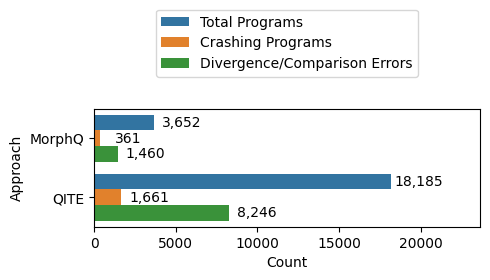

\newcommand{\TotalMorphQPrograms}{3,652}
\newcommand{\TotalOursPrograms}{18,185}
\newcommand{\RatioNewProgramsBestThenMorphQ}{4.98}
\newcommand{\TotalMorphQCrashes}{361}
\newcommand{\TotalOursCrashes}{1,661}
\newcommand{\RatioNewCrashesBestThenMorphQ}{4.60}
\newcommand{\TotalMorphQDivergences}{1,460}
\newcommand{\TotalOursDivergences}{8,246}
\newcommand{\RatioNewDivergencesBestThenMorphQ}{5.65}


In [275]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar plot
fig, ax = plt.subplots(figsize=(5, 6))
bar_plot = sns.barplot(
    y='Approach', x='Count',
    hue='Category',
    data=df_combined,
    ax=ax
)

# Add values on top of each column
for p in bar_plot.patches:
    if p.get_width() != 0:
        bar_plot.annotate(
            format(p.get_width(), ',.0f'),
            (p.get_width(), p.get_y() + p.get_height() / 2.),
            ha='center', va='center',
            xytext=(20, 0),
            textcoords='offset points')

# Add labels and title
ax.set_ylabel('Approach')
ax.set_xlim(0, max(df_combined['Count']) * 1.3)
ax.set_xlabel('Count')

# Place the legend on the top center
ax.legend(
    loc='upper center', bbox_to_anchor=(0.5, 1.9), ncol=1)

# Display the plot
plt.tight_layout()
plt.show()
output_path = os.path.join(
    "images", "comparison_morphq_total_crashing_divergences.pdf")
fig.savefig(output_path)

print("\\newcommand{\\TotalMorphQPrograms}{"+f"{n_morphq_programs:,.0f}"+"}")
print("\\newcommand{\\TotalOursPrograms}{"+f"{n_programs:,.0f}"+"}")
ratio_new_programs = n_programs / n_morphq_programs
print("\\newcommand{\\RatioNewProgramsBestThenMorphQ}{" +
      f"{ratio_new_programs:.2f}" + "}")

print("\\newcommand{\\TotalMorphQCrashes}{"+f"{n_morphq_crashes:,.0f}"+"}")
print("\\newcommand{\\TotalOursCrashes}{"+f"{n_crash_errors:,.0f}"+"}")
ratio_new_crashes = n_crash_errors / n_morphq_crashes
print("\\newcommand{\\RatioNewCrashesBestThenMorphQ}{" +
      f"{ratio_new_crashes:.2f}" + "}")

print("\\newcommand{\\TotalMorphQDivergences}{" +
      f"{n_morphq_divergences:,.0f}" + "}")
print(
    "\\newcommand{\\TotalOursDivergences}{"+f"{n_comparisons_errors:,.0f}"+"}")
ratio_new_divergences = n_comparisons_errors / n_morphq_divergences
print("\\newcommand{\\RatioNewDivergencesBestThenMorphQ}{" +
      f"{ratio_new_divergences:.2f}" + "}")

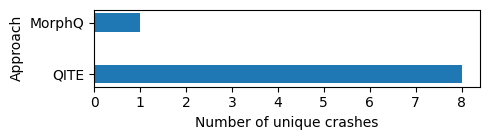

In [277]:

# Plotting the fourth bar chart
fig_errors, ax_errors = plt.subplots(figsize=(5, 1.5))

unique_crash_counts = [n_unique_crashes, n_unique_crashes_morphq]

ax_errors.barh(approaches, unique_crash_counts, bar_width)
ax_errors.set_xlabel('Number of unique crashes')
ax_errors.set_ylabel('Approach')

plt.tight_layout()
plt.show()

# Save the fourth bar chart as a PDF
output_path_errors = os.path.join(
    "images", "comparison_morphq_unique_crashes.pdf")
fig_errors.savefig(output_path_errors)